# TB312 - Aplicações envolvendo técnicas de processamento de sinais
### Módulo 2 - Fundamentos de filtragem adaptativa

---

**Prof. Eduardo Vinícius Kuhn**  
**Contato:** kuhn@utfpr.edu.br  
**Instituição:** Universidade Tecnológica Federal do Paraná (UTFPR)  
**Departamento:** Engenharia Eletrônica

---

<table>
<tr>
<td valign="top"> <!-- Tabela de Comandos Markdown -->

### Comandos úteis para células Markdown
| Comando             | Ação                             |
|---------------------|----------------------------------|
| `#`                 | Título de nível 1 (maior)        |
| `##`                | Título de nível 2                |
| `###`               | Título de nível 3                |
| `-` ou `*`          | Item de lista não ordenada       |
| `1.`, `2.`, etc.    | Item de lista ordenada           |
| `**texto**`         | Texto em negrito                 |
| `*texto*` ou `_texto_` | Texto em itálico             |

</td>
<td width="20"> <!-- Espaço vazio entre as colunas -->
</td>
<td valign="top"> <!-- Tabela de Atalhos do Google Colab -->

### Atalhos úteis no Google Colab
| Atalho              | Ação                                          |
|---------------------|-----------------------------------------------|
| `Ctrl + Enter`      | Executar célula                               |
| `Shift + Enter`     | Executar célula e ir para a próxima           |
| `Alt + Enter`       | Executar célula e inserir uma nova abaixo     |
| `Ctrl + /`          | Comentar a linha atual                        |
| `Ctrl + M + Y`      | Converte célula para código                   |
| `Ctrl + M + M`      | Converte célula para markdown                 |
| `Ctrl + M + A`      | Inserir célula de código acima                |
| `Ctrl + M + B`      | Inserir célula de código abaixo               |
| `Ctrl + M + D`      | Deletar célula                                |
| `Ctrl + M + Z`      | Desfazer última ação (dentro de uma célula)   |
| `Ctrl + M + H`      | Localizar e substituir                        |

</td>
</tr>
</table>


## Experimento 1 - Identificação de sistema
Busca-se obter a melhor estimativa possível da resposta ao impulso do sistema desconhecido (planta).

![Topologia de identificação de sistemas.](https://raw.githubusercontent.com/eduardovkuhn/aplicacoes_proc_sinais/main/figuras/topologia_identificacao_sistema.png)

**Blocos básicos:**
- Sistema desconhecido (planta) caracteriza a resposta ao impulso que se deseja identificar.
- O filtro adaptativo tem seus coeficientes atualizados por um algoritmo adaptativo para atender um dado critério de desempenho.

**Terminologia:**
- Sinal de entrada $x(n)$
- Sinal desejado $d(n)$
- Ruído de medição $z(n)$
- Estimativa do sinal desejado $\hat{d}(n)$
- Sinal de erro $e(n)$


### Algoritmo LMS

A equação de adaptação do algoritmo LMS é dada por
$$
\mathbf{w}(n+1)=\mathbf{w}(n)+\mu e(n)\mathbf{x}(n)
$$
onde $\mu$ denota o passo de adaptação,
$$
\mathbf{w}(n)=[w_{0}(n)\: w_{1}(n)\cdots w_{M-1}(n)]^{\mathrm{T}}
$$
é o vetor de coeficientes do filtro adaptativo,
$$
\mathbf{x}(n)=[x(n)\: x(n-1)\cdots x(n-M+1)]^{\mathrm{T}}
$$
representa o vetor contendo as $M$ amostras mais recentes do sinal de entrada, enquanto
\begin{align}
e(n) &= d(n)-\hat{d}(n) \\
     &= d(n)- \sum_{k=0}^{M-1}w_k(n)x(n-k)\\
     &= d(n)-\mathbf{w}^{\mathrm{T}}(n)\mathbf{x}(n).
\end{align}
caracteriza o sinal de erro.


**References:**

- D. G. Manolakis, V. K. Ingle, and S. M. Kogon, "Statistical and Adaptive Signal Processing: Spectral Estimation, Signal Modeling, Adaptive Filtering and Array Processing," 2000.
- Ali H. Sayed, *Adaptive Filters*, 2nd ed., IEEE-Wiley: Hoboken, N.J., 2008.
- Simon Haykin, *Adaptive Filter Theory*, 5th ed., Pearson: Harlow, U.K., 2013.






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scs
from ipywidgets import interact, IntSlider

# Define o tamanho da figura
figsize = (16 / 2.54, 9 / 2.54)

# Parâmetros do algoritmo
M = 40                       # Ordem do filtro
mu = 0.003                  # Tamanho do passo
w0 = np.zeros(M)             # Valores iniciais de w(n)

# Parâmetros das simulações
N = int(6e3)    	         # Número de iterações
n = np.arange(N)             # Escala de tempo
NR = 200                     # Número de realizações

# Características da entrada
varx = 0.1                     # Variância
a = np.array([1, 0])         # Coeficientes de correlação, ou seja, um AR(P)
P = len(a)                   # Ordem do processo AR

# Determinar o ganho de saída de acordo com varx
if (P - 1) == 1:
    varv = varx*(1 - a[1]**2)
elif (P - 1) == 2:
    varv = varx*(1 - a[2])*((1 + a[2])**2 - a[1]**2)/(1 + a[2])
else:
    print('A ordem do AR está incorreta!')

# Não modificar
b = np.sqrt(varv)*np.array([1])

# Características do ruído
varz = 1e-4
Jms_min = varz

# Planta a ser identificada
w_opt = np.sinc(np.arange(M) / np.pi)

# Normalizar os coeficientes da planta
w_opt = w_opt / np.sqrt(np.dot(w_opt, w_opt))

#LMS
M = 32                     
mu = 0.003                
varx = 1   

In [ ]:
def LMS_algorithm(N, M, mu, w0, x, d):

    # Pré-aloca memória com zeros
    x_temp = np.zeros(M)
    y, e, w = np.zeros(N), np.zeros(N), w0

    # Para armazenar o histórico dos coeficientes
    whist = np.zeros((M, N))

    # Executa o algoritmo NLMS
    for k in range(N):

        # Desloca as amostras e insere um novo valor na primeira posição
        x_temp[1:], x_temp[0] = x_temp[:-1], x[k]

        # Filtra a entrada
        y[k] = np.dot(w, x_temp)

        # Calcula o erro
        e[k] = d[k] - y[k]

        # Atualiza o vetor de coeficientes
        w = w + mu * e[k] * x_temp

        # Armazena o vetor de coeficientes
        whist[:, k] = w

    # Avalia o erro quadrático
    J = e**2

    return y, w, whist, e, J

#NLMS
M = 32                     
mu = 0.3                
varx = 1   


In [ ]:
# Etapa 1 - Implementação do algoritmo NLMS

def NLMS_algorithm(N, M, mu, w0, x, d):

    #prevenir divisao por 0
    epsilon = 1e-3

    # Pré-aloca memória com zeros
    x_temp = np.zeros(M)
    x_T_temp = np.zeros(M)
    y, e, w = np.zeros(N), np.zeros(N), w0

    # Para armazenar o histórico dos coeficientes
    whist = np.zeros((M, N))

    # Executa o algoritmo NLMS
    for k in range(N):

        # Desloca as amostras e insere um novo valor na primeira posição
        x_temp[1:], x_temp[0] = x_temp[:-1], x[k]

        # Filtra a entrada
        y[k] = np.dot(w, x_temp)

        # Calcula o erro
        e[k] = d[k] - y[k]

        # Atualiza o vetor de coeficientes
        w = w + (mu * e[k] * x_temp / (epsilon + np.dot(x_temp.transpose(), x_temp)))

        # Armazena o vetor de coeficientes
        whist[:, k] = w

    # Avalia o erro quadrático
    J = e**2

    return y, w, whist, e, J

#sign_regressor_LMS
M = 32                     
mu = 0.003                
varx = 1   

In [ ]:
import numpy as np

def sign(x):
    return np.where(x >= 0, 1, -1)

def sign_regressor_LMS(N, M, mu, w0, x, d):
    # Pré-aloca memória com zeros
    x_temp = np.zeros(M)
    y, e, w = np.zeros(N), np.zeros(N), w0

    # Para armazenar o histórico dos coeficientes
    whist = np.zeros((M, N))

    # Executa o algoritmo Sign Regressor LMS
    for k in range(N):
        # Desloca as amostras e insere um novo valor na primeira posição
        x_temp[1:] = x_temp[:-1]
        x_temp[0] = x[k]

        # Filtra a entrada
        y[k] = np.dot(w, x_temp)

        # Calcula o erro
        e[k] = d[k] - y[k]

        # Atualiza o vetor de coeficientes
        w = w + (mu * e[k] * sign(x_temp))

        # Armazena o vetor de coeficientes
        whist[:, k] = w

    # Avalia o erro quadrático
    J = e**2

    return y, w, whist, e, J



#sign LMS
M = 40                     
mu = 0.003                
varx = 0.1   

In [ ]:
import numpy as np

def sign(x):
    return np.where(x >= 0, 1, -1)

def sign_LMS(N, M, mu, w0, x, d):
    # Pré-aloca memória com zeros
    x_temp = np.zeros(M)
    y, e, w = np.zeros(N), np.zeros(N), w0

    # Para armazenar o histórico dos coeficientes
    whist = np.zeros((M, N))

    # Executa o algoritmo Sign Regressor LMS
    for k in range(N):
        # Desloca as amostras e insere um novo valor na primeira posição
        x_temp[1:] = x_temp[:-1]
        x_temp[0] = x[k]

        # Filtra a entrada
        y[k] = np.dot(w, x_temp)

        # Calcula o erro
        e[k] = d[k] - y[k]

        # Atualiza o vetor de coeficientes
        w = w + (mu * sign(e[k]) * x_temp)

        # Armazena o vetor de coeficientes
        whist[:, k] = w

    # Avalia o erro quadrático
    J = e**2

    return y, w, whist, e, J



Leaky LMS

gamma = 0.8

In [ ]:
def leaky_LMS(N, M, mu, w0, x, d):

    # gamma
    gamma = 0.8

    # Pré-aloca memória com zeros
    x_temp = np.zeros(M)
    x_T_temp = np.zeros(M)
    y, e, w = np.zeros(N), np.zeros(N), w0

    # Para armazenar o histórico dos coeficientes
    whist = np.zeros((M, N))

    # Executa o algoritmo NLMS
    for k in range(N):

        # Desloca as amostras e insere um novo valor na primeira posição
        x_temp[1:], x_temp[0] = x_temp[:-1], x[k]

        # Filtra a entrada
        y[k] = np.dot(w, x_temp)

        # Calcula o erro
        e[k] = d[k] - y[k]

        # Atualiza o vetor de coeficientes
        w = ((1 - (mu * gamma)) * w) + (mu * e[k] * x_temp)

        # Armazena o vetor de coeficientes
        whist[:, k] = w

    # Avalia o erro quadrático
    J = e**2 + gamma*np.dot(w.T, w)

    return y, w, whist, e, J

In [ ]:
def estima_matriz_de_correlacao(sinal, M = 4):

    # Inicializa as variáveis
    x_temp, R = np.zeros((M, 1)), np.zeros((M, M))

    for x in sinal:
        # Desloca as amostras e insere um novo valor na primeira posição
        x_temp[1:], x_temp[0] = x_temp[:-1], x

        # Calcula a matriz de correlação e acumula
        R += x_temp @ x_temp.T

    # Retorna a matriz normalizada pelo tamanho do sinal
    return R/(sinal.size)

In [ ]:
# Alocar memória para as variáveis
Jmed1, Jmed_ex1 = np.zeros(N), np.zeros(N)
Wmed1 = np.zeros((M, N))

Jmed2, Jmed_ex2 = np.zeros(N), np.zeros(N)
Wmed2 = np.zeros((M, N))

Jmed3, Jmed_ex3 = np.zeros(N), np.zeros(N)
Wmed3 = np.zeros((M, N))

Jmed4, Jmed_ex4 = np.zeros(N), np.zeros(N)
Wmed4 = np.zeros((M, N))

Jmed5, Jmed_ex5 = np.zeros(N), np.zeros(N)
Wmed5 = np.zeros((M, N))

for realization in range(NR):

    # Gerar vetor de ruído
    z = np.sqrt(varz)*np.random.randn(N)

    # Gerar dados de entrada
    x = np.random.randn(N)

    # Implementar equações AR(P)
    x = scs.lfilter(b, a, x)

    # Gerar o sinal desejado
    d = scs.lfilter(w_opt, 1, x) + z

    # Executar o algoritmo LMS considerando uma estrutura FIR
    y1, w1, whist1, e1, J1 = LMS_algorithm(N, M, 0.003, w0, x, d)
    y2, w2, whist2, e2, J2 = NLMS_algorithm(N, M, 0.3, w0, x, d)
    y3, w3, whist3, e3, J3 = sign_LMS(N, M, 0.003, w0, x, d)
    y4, w4, whist4, e4, J4 = sign_regressor_LMS(N, M, 0.003, w0, x, d)
    y5, w5, whist5, e5, J5 = leaky_LMS(N, M, 0.005, w0, x, d)

    # Armazena valores
    Jmed1 += J1
    Jmed_ex1 += (e1 - z)**2
    Wmed1 += whist1

    Jmed2 += J2
    Jmed_ex2 += (e2 - z)**2
    Wmed2 += whist2

    Jmed3 += J3
    Jmed_ex3 += (e3 - z)**2
    Wmed3 += whist3

    Jmed4 += J4
    Jmed_ex4 += (e4 - z)**2
    Wmed4 += whist4

    Jmed5 += J5
    Jmed_ex5 += (e5 - z)**2
    Wmed5 += whist5

Jmed1 /= NR
Jmed_ex1 /= NR
Wmed1 /= NR

Jmed2 /= NR
Jmed_ex2 /= NR
Wmed2 /= NR

Jmed3 /= NR
Jmed_ex3 /= NR
Wmed3 /= NR

Jmed4 /= NR
Jmed_ex4 /= NR
Wmed4 /= NR

Jmed5 /= NR
Jmed_ex5 /= NR
Wmed5 /= NR

# Converter para dB
Jmed_dB1 = 10 * np.log10(Jmed1)
Jmed_ex_dB1 = 10 * np.log10(Jmed_ex1)

Jmed_dB2 = 10 * np.log10(Jmed2)
Jmed_ex_dB2 = 10 * np.log10(Jmed_ex2)

Jmed_dB3 = 10 * np.log10(Jmed3)
Jmed_ex_dB3 = 10 * np.log10(Jmed_ex3)

Jmed_dB4 = 10 * np.log10(Jmed4)
Jmed_ex_dB4 = 10 * np.log10(Jmed_ex4)

Jmed_dB5 = 10 * np.log10(Jmed5)
Jmed_ex_dB5 = 10 * np.log10(Jmed_ex5)

codigo abaixo modificado para o regression

40
[ 6.97034140e-01  5.86534005e-01  3.16905675e-01  3.27884878e-02
 -1.31879294e-01 -1.33680591e-01 -3.24603569e-02  6.54202984e-02
  8.62020594e-02  3.19178505e-02 -3.79201287e-02 -6.33661195e-02
 -3.11674702e-02  2.25285207e-02  4.93205105e-02  3.02181884e-02
 -1.25424026e-02 -3.94192279e-02 -2.90813194e-02  5.49839642e-03
  3.18177004e-02  2.77703592e-02 -2.80439307e-04 -2.56454136e-02
 -2.63007931e-02 -3.69014753e-03  2.04434336e-02  2.46898768e-02
  6.74394940e-03 -1.59508784e-02 -2.29563925e-02 -9.08477525e-03
  1.20113507e-02  2.11203850e-02  1.08467263e-02 -8.52736968e-03
 -1.92028811e-02 -1.21234608e-02  5.43628993e-03  1.72255971e-02]


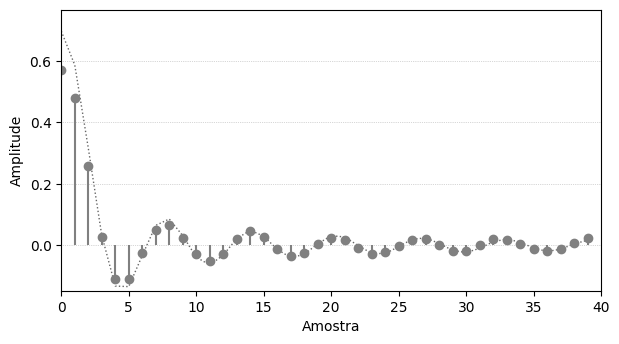

In [ ]:
# Cria figura para plotar o valor final dos coeficientes
fig, ax = plt.subplots(figsize=figsize)

print(M)
print(w_opt)

ax.plot(np.arange(M),
        w_opt,
        linestyle = ':',
        color='0.4',
        linewidth=1)

mline, slines, bline = ax.stem(np.arange(M), w1,
                                markerfmt='o',
                                linefmt='-',
                                basefmt=' ')
mline.set_color('0.5')
slines.set_color('0.5')
bline.set_color('0.5')

# Adiciona linhas de grade nos eixos
ax.grid(axis='y',
        linestyle=':',
        linewidth=.5)

# Define rótulos para os eixos x e y
ax.set(xlabel = 'Amostra',
       ylabel = 'Amplitude')

# Ajusta os limites dos eixos
ax.set(xlim=[0, M],
       ylim=[min(w_opt) * 1.1, max(w_opt) * 1.1])

# Ajusta o layout para minimizar o espaço não utilizado.
plt.tight_layout()
# Não é necessário para o backend do Jupyter.
plt.show()

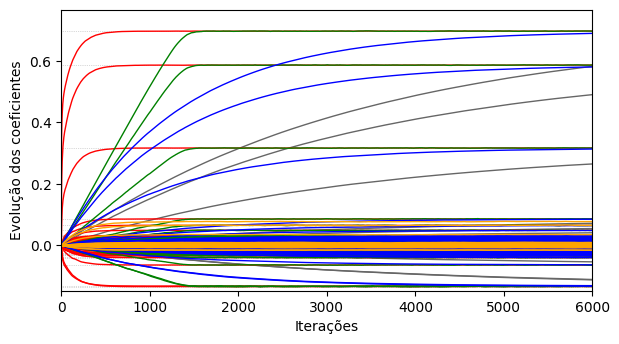

In [ ]:
# Cria figura para plotar a evolução dos coeficientes
fig, ax = plt.subplots(figsize=figsize)

# Adiciona linhas de grade nos valores de w_opt
for value in w_opt:
    ax.axhline(y=value, color='0.7', linestyle=':', linewidth=0.5)

ax.plot(n,
        Wmed1.T,
        linestyle = '-',
        color='0.4',
        linewidth=1)
ax.plot(n,
        Wmed2.T,
        linestyle = '-',
        color='red',
        linewidth=1)
ax.plot(n,
        Wmed3.T,
        linestyle = '-',
        color='green',
        linewidth=1)
ax.plot(n,
        Wmed4.T,
        linestyle = '-',
        color='blue',
        linewidth=1)
ax.plot(n,
        Wmed5.T,
        linestyle = '-',
        color='orange',
        linewidth=1)

# Define rótulos para os eixos x e y
ax.set(xlabel = 'Iterações',
       ylabel = 'Evolução dos coeficientes')

# Ajusta os limites dos eixos
ax.set(xlim=[0, N],
       ylim=[min(w_opt) * 1.1, max(w_opt) * 1.1])

# Ajusta o layout para minimizar o espaço não utilizado.
plt.tight_layout()
# Não é necessário para o backend do Jupyter.
plt.show()

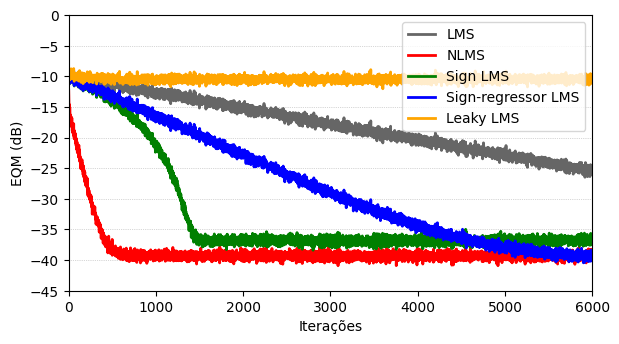

In [ ]:
# Cria figura para plotar o EQM
fig, ax = plt.subplots(figsize=figsize)

ax.plot(n,
        Jmed_dB1,
        color='0.4',
        linewidth=2,
        label='LMS')

ax.plot(n,
        Jmed_dB2,
        color='red',
        linewidth=2,
        label='NLMS')

ax.plot(n,
        Jmed_dB3,
        color='green',
        linewidth=2,
        label='Sign LMS')

ax.plot(n,
        Jmed_dB4,
        color='blue',
        linewidth=2,
        label='Sign-regressor LMS')

ax.plot(n,
        Jmed_dB5,
        color='orange',
        linewidth=2,
        label='Leaky LMS')

# Define rótulos para os eixos x e y
ax.set(xlabel = 'Iterações',
       ylabel = 'EQM (dB)')

# Adiciona linhas de grade nos eixos
ax.grid(axis='y',
        linestyle=':',
        linewidth=.5)

# Ajusta os limites dos eixos
ax.set(xlim=[0, N],
       ylim=[10*np.log10(varz)-5, 0])

# Ajusta o layout para minimizar o espaço não utilizado.
plt.tight_layout()
# Coloca legenda
plt.legend(loc='upper right')
# Não é necessário para o backend do Jupyter.
plt.show()

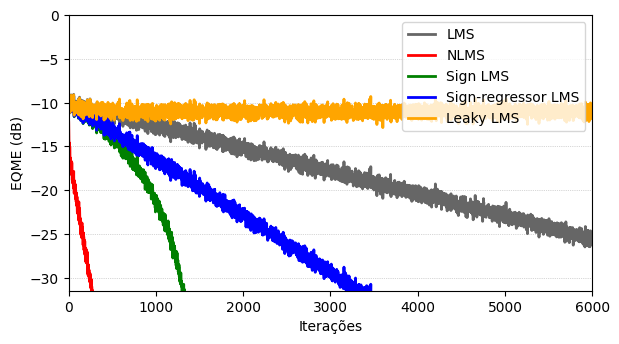

In [ ]:
# Cria figura para plotar o EQME
fig, ax = plt.subplots(figsize=figsize)

ax.plot(n,
        Jmed_ex_dB1,
        color='0.4',
        linewidth=2,
        label='LMS')

ax.plot(n,
        Jmed_ex_dB2,
        color='red',
        linewidth=2,
        label='NLMS')

ax.plot(n,
        Jmed_ex_dB3,
        color='green',
        linewidth=2,
        label='Sign LMS')

ax.plot(n,
        Jmed_ex_dB4,
        color='blue',
        linewidth=2,
        label='Sign-regressor LMS')

ax.plot(n,
        Jmed_ex_dB5,
        color='orange',
        linewidth=2,
        label='Leaky LMS')

# Define rótulos para os eixos x e y
ax.set(xlabel = 'Iterações',
       ylabel = 'EQME (dB)')

# Adiciona linhas de grade nos eixos
ax.grid(axis='y',
        linestyle=':',
        linewidth=.5)

# Ajusta os limites dos eixos
ax.set(xlim=[0, N],
       ylim=[min(Jmed_ex_dB1)-5, 0])

# Ajusta o layout para minimizar o espaço não utilizado.
plt.tight_layout()
# Coloca legenda
plt.legend(loc='upper right')
# Não é necessário para o backend do Jupyter.
plt.show()

In [ ]:
# Função para atualizar o gráfico
def update_plot(nn):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Subplot 1: Evolução dos coeficientes
    ax1.plot(np.arange(M),
             w_opt,
             linestyle = ':',
             color='0.4',
             linewidth=1)

    mline, slines, bline = ax1.stem(np.arange(M),
                                    Wmed1[:, nn],
                                    markerfmt='o',
                                    linefmt='-',
                                    basefmt=' ')
    mline.set_color('0.5')
    slines.set_color('0.5')
    bline.set_color('0.5')

    ax1.set(xlabel = 'Amostra',
            ylabel = 'Amplitude')

    ax1.set(xlim=[0, M],
            ylim=[min(w_opt) * 1.1, max(w_opt) * 1.1])

    ax1.grid(axis='y',
            linestyle=':',
            linewidth=.5)


    # Subplot 2: EQM
    ax2.plot(np.arange(0, nn+1, intv),
             Jmed_dB1[0:nn+1:intv],
             color='0.4',
             linewidth=2)
    ax2.plot(np.arange(0, nn+1, intv),
             Jmed_dB2[0:nn+1:intv],
             color='red',
             linewidth=2)
    ax2.plot(np.arange(0, nn+1, intv),
             Jmed_dB3[0:nn+1:intv],
             color='green',
             linewidth=2)
    ax2.plot(np.arange(0, nn+1, intv),
             Jmed_dB4[0:nn+1:intv],
             color='blue',
             linewidth=2)
    ax2.plot(np.arange(0, nn+1, intv),
             Jmed_dB5[0:nn+1:intv],
             color='orange',
             linewidth=2)

    ax2.set(xlim=[0, N],
            ylim=[10*np.log10(varz)-5, 0])

    ax2.set(xlabel = 'Iterações',
            ylabel = 'EQM (dB)')

    ax2.grid(axis='y',
            linestyle=':',
            linewidth=.5)

    # Ajusta o layout para minimizar o espaço não utilizado.
    plt.tight_layout()
    # Não é necessário para o backend do Jupyter.
    plt.show()

# Cria o slider interativo
intv = 5
slider = IntSlider(min=0, max=N-1, step=intv, value=0, description='Iterações')

# Cria a interface interativa
interact(update_plot, nn=slider)

interactive(children=(IntSlider(value=0, description='Iterações', max=5999, step=5), Output()), _dom_classes=(…

<function __main__.update_plot(nn)>

## Experimento \#1: Implementação prática

Este experimento tem por objetivo a implementação prática de algoritmos adaptativos no contexto de um problema de identificação de sistema, visando fornecer subsídios para entender
- o impacto dos parâmetros no comportamento do algoritmo; e
- como comparar diferentes algoritmos adaptativos.

#### **Etapa 1**
- Executar o código disponibilizado.
- Entender o resultado observado nas curvas.
- Avaliar o comportamento da evolução dos coeficientes e do EQM.
- Modificar os parâmetros $M$, $\sigma_z^2$, $\mu$, $\mathbf{a}$.
- Implementar o algoritmo NLMS e conduzir comparações de desempenho.

A equação de adaptação do algoritmo NLMS é dada por
$$
\mathbf{w}(n+1) = \mathbf{w}(n) + \mu \dfrac{e(n) \mathbf{x}(n)}{\varepsilon + \mathbf{x}^\textrm{T}(n)\mathbf{x}(n)}
$$
onde $\mu$ denota o passo de adaptação, $\varepsilon$ é o parâmetro de regularização que visa prevenir divisão por zero,
$$
\mathbf{w}(n) = [w_{0}(n)\: w_{1}(n) \cdots w_{M-1}(n)]^{\mathrm{T}}
$$
é o vetor de coeficientes do filtro adaptativo,
$$
\mathbf{x}(n) = [x(n)\: x(n-1) \cdots x(n-M+1)]^{\mathrm{T}}
$$
representa o vetor contendo as $M$ amostras mais recentes do sinal de entrada, enquanto
\begin{align}
e(n) &= d(n) - \hat{d}(n) \\
     &= d(n) - \sum_{k=0}^{M-1} w_k(n) x(n-k) \\
     &= d(n) - \mathbf{w}^{\mathrm{T}}(n) \mathbf{x}(n).
\end{align}
caracteriza o sinal de erro.

#### **Etapa 2**
- Estudar o artigo/material adicional apresentado (acesse [o repositório](https://github.com/eduardovkuhn/aplicacoes_proc_sinais/tree/main/experimentos/artigos)).
- Criar uma nova função para implementar o algoritmo descrito.
- Identificar valores típicos para os parâmetros do algoritmo.
- Realizar comparações de desempenho (curvas sobrepostas).


*É importante que ao final das atividades, as duplas discutam entre si para consolidar o conhecimento adquirido e estejam prontas para apresentar suas observações e conclusões.*


**Quando concluído, me avisem.**